In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13CH2'
os.chdir(new_path)


In [2]:
import ipcmagic
import ipyparallel as ipp
# start a cluster of 4 engines
%ipcluster start -n 4 --launcher srun

  0%|          | 0/4 [00:00<?, ?engine/s]

In [3]:
%%px

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stderr:3] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[stderr:1] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[stderr:0] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[stderr:2] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [4]:
%%px

def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


### Control parameters

In [5]:
%%px 

GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [6]:
%%px

cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [7]:
%%px 

lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:3] Condition number: 2.8e+04


[stdout:2] Condition number: 2.8e+04


[stdout:1] Condition number: 2.8e+04


[stdout:0] Condition number: 2.8e+04


In [8]:
%%px 

bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [9]:
%%px 

H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

nodes = [0,810,1116,1278,1584,2394]

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

# Define broadening factor for the Green's function calculation
eta = 1e-3

In [10]:
%%px

# Define the path to the reference data for transmission
ref_path = "published_reference/transmission"

# Load the reference LCAO transmission data from a file, where reference is the data from "Strong correlation effect paper"
E, Tref_dft = np.load(f"{ref_path}/ET_dft.npy")

### Use the LCAO Hamiltonian to compute transmission function

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

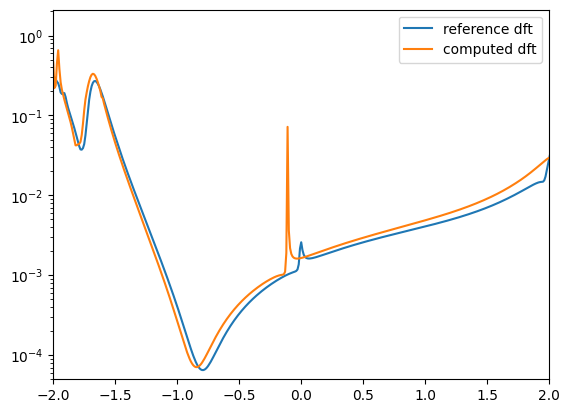

In [11]:
%%px

H_lcao2 = H_lcao[None,...]
S_lcao2 = S_lcao[None,...]

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_lcao2[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao2)
remove_pbc(device_basis, S_lcao2)

# Initialize self-energy list for left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lcao2[0], S_lcao2[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='coupling',
                                 eta=eta)
# Define energy range for the Green's function calculation
de = 0.01
energies = np.arange(-3., 3. + de / 2., de).round(7)


# Calculate the transmission function T for each energy in the defined range
gd = GridDesc(energies, 1, float)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy)

T = gd.gather_energies(T)

if comm.rank == 0:
    # Plot the reference LCAO transmission data
    plt.plot(E, Tref_dft, label="reference dft")

    # Plot the computed LCAO transmission data
    plt.plot(energies, T, label="computed dft")

    # Set the y-axis to a logarithmic scale to better visualize the transmission data
    plt.yscale("log")
    plt.xlim(-2,2)
    plt.ylim(bottom=5e-5)
    plt.legend()

### Subdiagonalize C, N and H of LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

In [12]:
%%px 

# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

### Compute and plot transmission function

In [13]:
%%px

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sudiagonalized[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sudiagonalized)
remove_pbc(device_basis, S_sudiagonalized)

# Initialize self-energy list for left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sudiagonalized[0], S_sudiagonalized[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='coupling',
                                 eta=eta)

# Calculate the transmission function T for each energy in the defined range
gd = GridDesc(energies, 1, float)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy)

T = gd.gather_energies(T)



%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

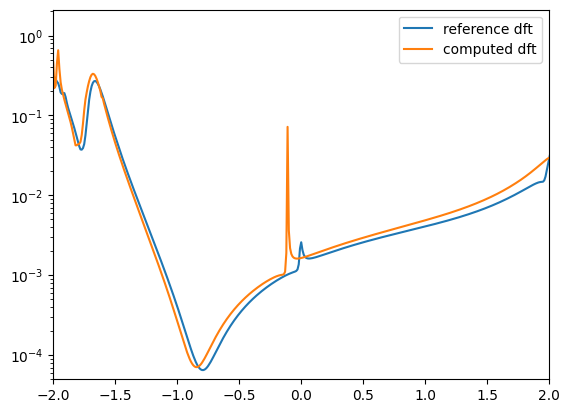

In [14]:
%%px

if comm.rank == 0:
    # Plot the reference LCAO transmission data
    plt.plot(E, Tref_dft, label="reference dft")

    # Plot the computed LCAO transmission data
    plt.plot(energies, T, label="computed dft")

    # Set the y-axis to a logarithmic scale to better visualize the transmission data
    plt.yscale("log")
    plt.xlim(-2,2)
    plt.ylim(bottom=5e-5)
    plt.legend()

### Subdiagonalize only C and look at T(E) 

In [15]:
%%px

# Define the species for subdiagonalization
SUBDIAG_SPECIES = ("C")

# Get the indices of atoms corresponding to the specified species in the basis
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices using the selected species
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the Hamiltonian and overlap matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]



%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

### Compute and plot transmission function

In [16]:
%%px

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sudiagonalized[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sudiagonalized)
remove_pbc(device_basis, S_sudiagonalized)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)


# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_sudiagonalized[0],
    S_sudiagonalized[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)
# Calculate the transmission function T for each energy in the defined range
gd = GridDesc(energies, 1, float)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy)

T = gd.gather_energies(T)



%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

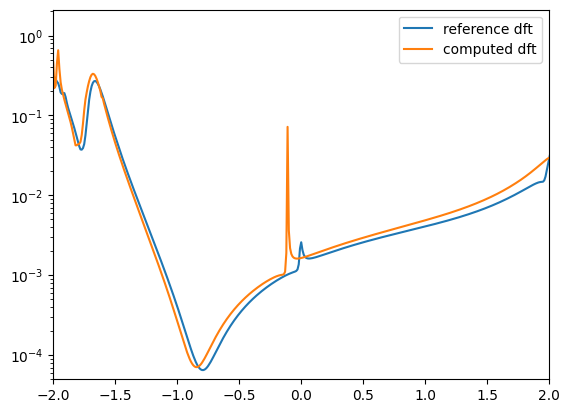

In [17]:
%%px

if comm.rank == 0:
    # Plot the reference LCAO transmission data
    plt.plot(E, Tref_dft, label="reference dft")

    # Plot the computed LCAO transmission data
    plt.plot(energies, T, label="computed dft")

    # Set the y-axis to a logarithmic scale to better visualize the transmission data
    plt.yscale("log")
    plt.xlim(-2,2)
    plt.ylim(bottom=5e-5)
    plt.legend()

### Analysis

- In all of the above computation of T(E), the following steps are taken
  - The self energy of the left and right leads are computed. (How should we take into account the Au tips?)
  - The Hamiltonian of the device (leads + bridge molecule) is subdiagonalized based on the atoms provided to subdiagonalize. This step is not done in the lcao Hamiltonian case (The first one) 
  - The H, S of the device are tridiagonalized. 
  - Green's function is computed with information from the tridiagonalized device Hamiltonian and the self-energies of the left and right leads.
  - None of the above steps include any cut-coupling or embedding procedure.

### Conclusion

- The transmission function remains unchanged regardless of subdiagonalization (as expected).
- The computed transmission functions are slightly shifted w.r.t the reference data.
- The Fano peak computed by me is sharper than that of the reference and also slightly shifted away from 0 eV. The reference Fano peak is almost exactly at 0 eV? Is there a physical significance to the position of the Fano peak?
- The peak around -2 eV is enhanced in my calculations compared to reference.
